In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tifffile as tiff 
import albumentations
import torch

In [179]:
'''
  id - The image ID.
  organ - The organ that the biopsy sample was taken from.
  data_source - Whether the image was provided by HuBMAP or HPA.
  img_height - The height of the image in pixels.
  img_width - The width of the image in pixels.
  pixel_size - The height/width of a single pixel from this image in micrometers. 
    All HPA images have a pixel size of 0.4 µm. For HuBMAP imagery the pixel size is 0.5 µm for kidney,
    0.2290 µm for large intestine, 0.7562 µm for lung, 0.4945    for spleen, and 6.263 µm for prostate.
  tissue_thickness - The thickness of the biopsy sample in micrometers. All HPA images have a thickness of 4 µm.
    The HuBMAP samples have tissue slice thicknesses 10 µm for kidney, 8 µm for large intestine, 4 µm for spleen,
    5 µm for lung, and 5 µm for prostate.
  rle - The target column. A run length encoded copy of the annotations. Provided for the training set only.
  age - The patient's age in years. Provided for the training set only.
  sex - The sex of the patient. Provided for the training set only.
'''
train = pd.read_csv('./train.csv', encoding='utf8')

# Descripcion vaga de los datos

In [180]:
train.describe()

,id,img_height,img_width,pixel_size,tissue_thickness,age
count,351.000000,351.000000,351.000000,3.510000e+02,351.0,351.000000
mean,16662.914530,2978.364672,2978.364672,4.000000e-01,4.0,60.364672
std,9863.945557,90.962085,90.962085,1.111808e-16,0.0,16.013327
min,62.000000,2308.000000,2308.000000,4.000000e-01,4.0,21.000000
25%,8229.000000,3000.000000,3000.000000,4.000000e-01,4.0,55.000000
50%,16609.000000,3000.000000,3000.000000,4.000000e-01,4.0,60.000000
75%,25630.500000,3000.000000,3000.000000,4.000000e-01,4.0,73.000000
max,32741.000000,3070.000000,3070.000000,4.000000e-01,4.0,84.000000


In [181]:
__quant = list(train.describe().columns)

for variable in train.columns:
  if (variable in __quant or variable == 'rle'): continue
  print(train[variable].unique())


['prostate' 'spleen' 'lung' 'kidney' 'largeintestine']
['HPA']
['Male' 'Female']


# Analisis Exploratorio

## Analisis variables cualitativas

### Organos conteo

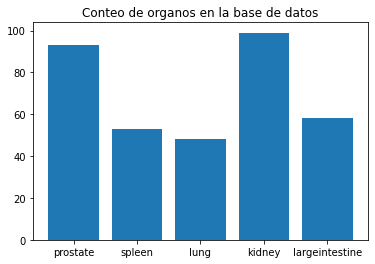

In [182]:
organs = []
counts = []
for organ in train['organ'].unique():
  organs.append(organ)
  counts.append(train['organ'].value_counts()[organ])
plt.bar(organs, counts)
plt.title('Conteo de organos en la base de datos')
plt.show()

### Organos y su distribucion de edad

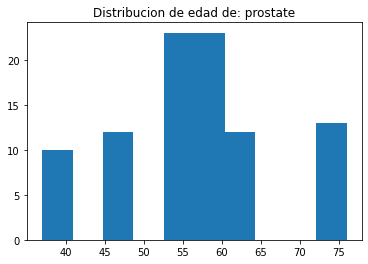

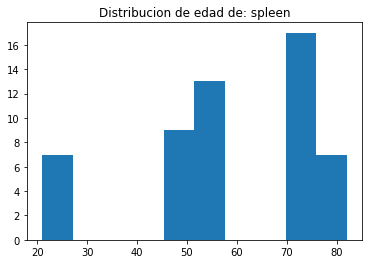

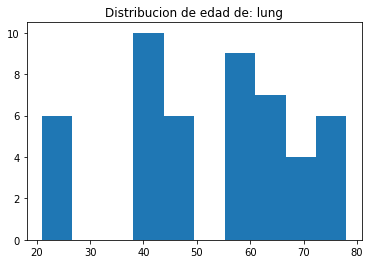

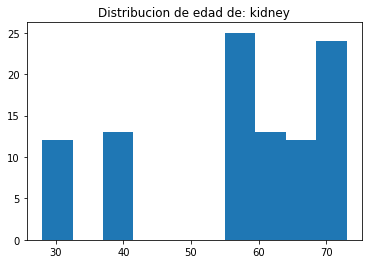

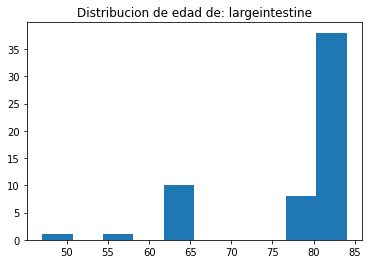

In [183]:
for organ in train['organ'].unique():
  plt.title('Distribucion de edad de: ' + organ)
  plt.hist(train.loc[train['organ'] == organ]['age'])
  plt.show()


### Organos y su distribucion por sexo

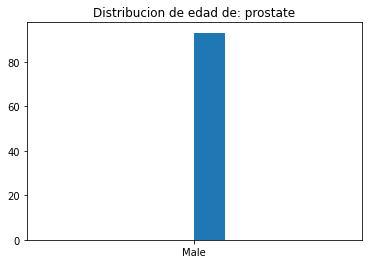

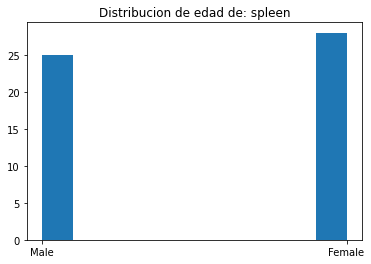

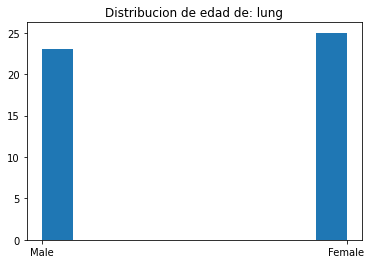

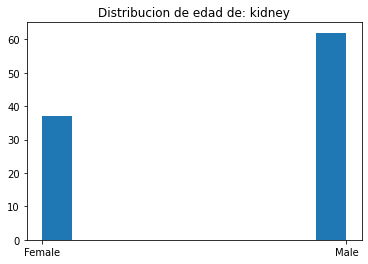

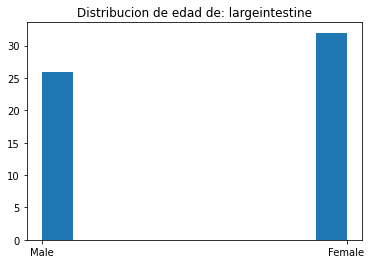

In [184]:
for organ in train['organ'].unique():
  plt.title('Distribucion de edad de: ' + organ)
  plt.hist(train.loc[train['organ'] == organ]['sex'])
  plt.show()

## Analisis variables cuantitativas

### Distribucion de edad

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='age', ylabel='Density'>

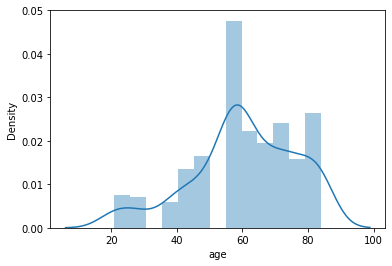

In [185]:
sns.distplot(train['age'])

### Distribucion de ancho de tejido

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='tissue_thickness', ylabel='Density'>

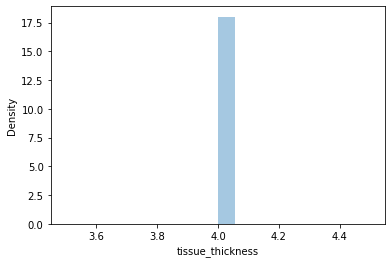

In [186]:
sns.distplot(train['tissue_thickness'])

## Analisis de fotografias

### Distribucion de tamanos de fotografias

#### Ancho

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='img_width', ylabel='Density'>

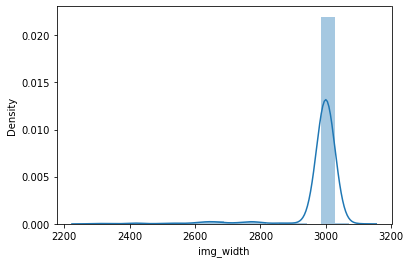

In [187]:
sns.distplot(train['img_width'])

#### Alto

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='img_height', ylabel='Density'>

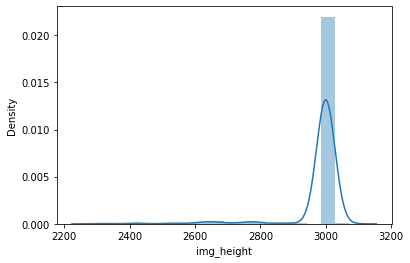

In [188]:
sns.distplot(train['img_height'])

#### Tamano pixel

c:\Users\andre\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


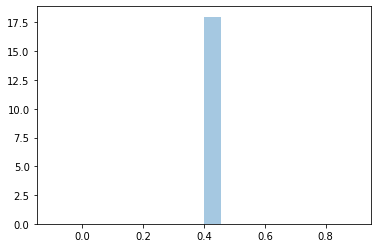

In [201]:
try:
    sns.distplot(train['pixel_size'])
except:
    ''

#### Resolucion imagenes

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

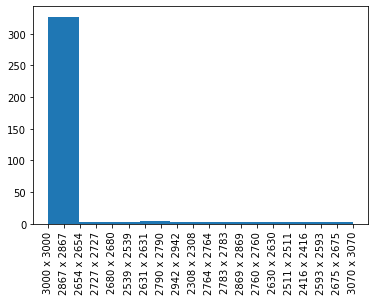

In [ ]:
train['resolution'] = train['img_width'].astype(str) + ' x ' + train['img_height'].astype(str)
plt.hist(train['resolution'])
plt.xticks(rotation='vertical')

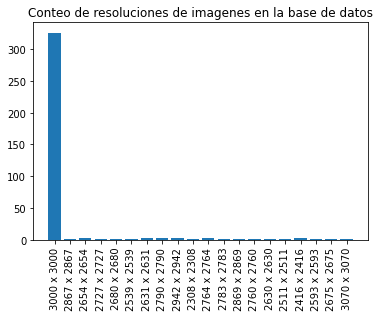

In [ ]:
resolutions = []
counts = []
for resolution in train['resolution'].unique():
  resolutions.append(resolution)
  counts.append(train['resolution'].value_counts()[resolution])
plt.bar(resolutions, counts)
plt.title('Conteo de resoluciones de imagenes en la base de datos')
plt.xticks(rotation='vertical')
plt.show()

# Imagenes

In [228]:
selected = train[train["id"].isin([62, 351, 4301, 5995, 6021, 6120, 7397, 8227, 7359, 32741, 9517, 737, 4777, 5086, 32412])][['id', 'organ',  'age', 'sex']]
selected = selected.set_index('id').sort_index()

In [230]:
selected

,organ,age,sex
id,,,
62,kidney,59.0,Male
351,largeintestine,65.0,Female
737,prostate,55.0,Male
4301,lung,65.0,Male
4777,kidney,61.0,Male
5086,lung,65.0,Male
5995,prostate,61.0,Male
6021,kidney,41.0,Female
6120,prostate,37.0,Male


In [232]:
from torch.utils.data import Dataset
def mask2rle(img): # encoder
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels= img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle2mask(mask_rle, shape): # decoder 
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T
    
class HuBMAPDataset(Dataset):
    def __init__(self,df):
        self.ids = selected.index.to_list()
        self.rle = df['rle'].values
        self.width = df['img_width'].values
        self.height = df['img_height'].values
    def __len__(self):  
        return len(self.ids)
    def __getitem__(self,idx):
        img  = tiff.imread('train_images/' + str(self.ids[idx]) +'.tiff')
        print('selected sample', self.ids[idx])
        mask = rle2mask(self.rle[idx], (self.height[idx],self.width[idx]))

        return img,mask 

In [233]:
dataset = HuBMAPDataset(selected) 

In [242]:
image, mask = dataset[8]

selected sample 6120


In [243]:
mask.shape

(3000, 3000)

In [244]:
image.shape

(3000, 3000, 3)

(-0.5, 2999.5, 2999.5, -0.5)

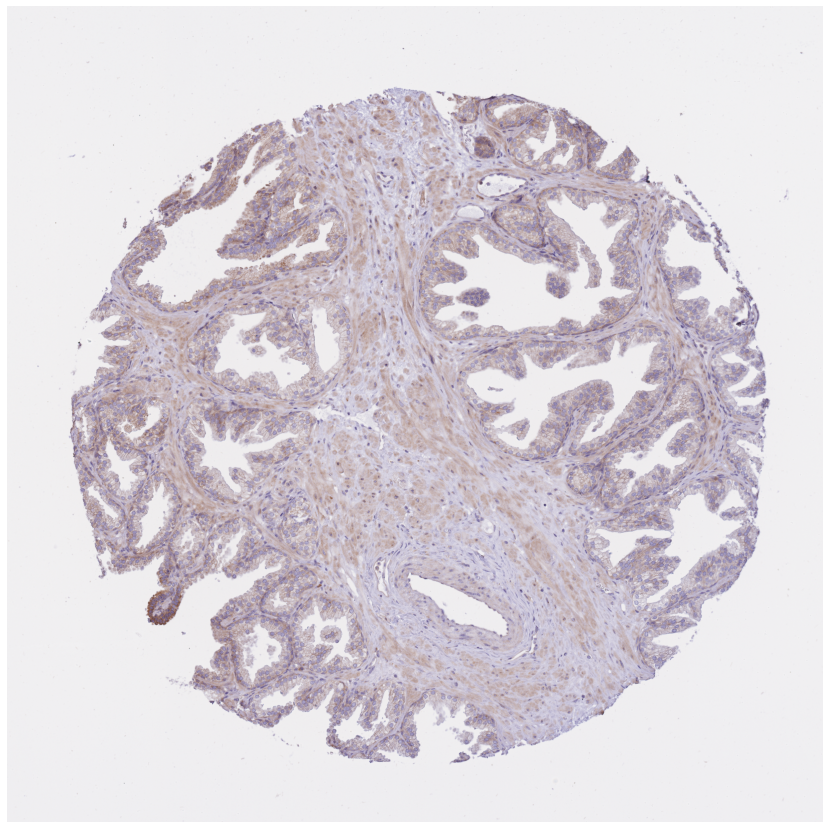

In [245]:
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis("off")

(-0.5, 2999.5, 2999.5, -0.5)

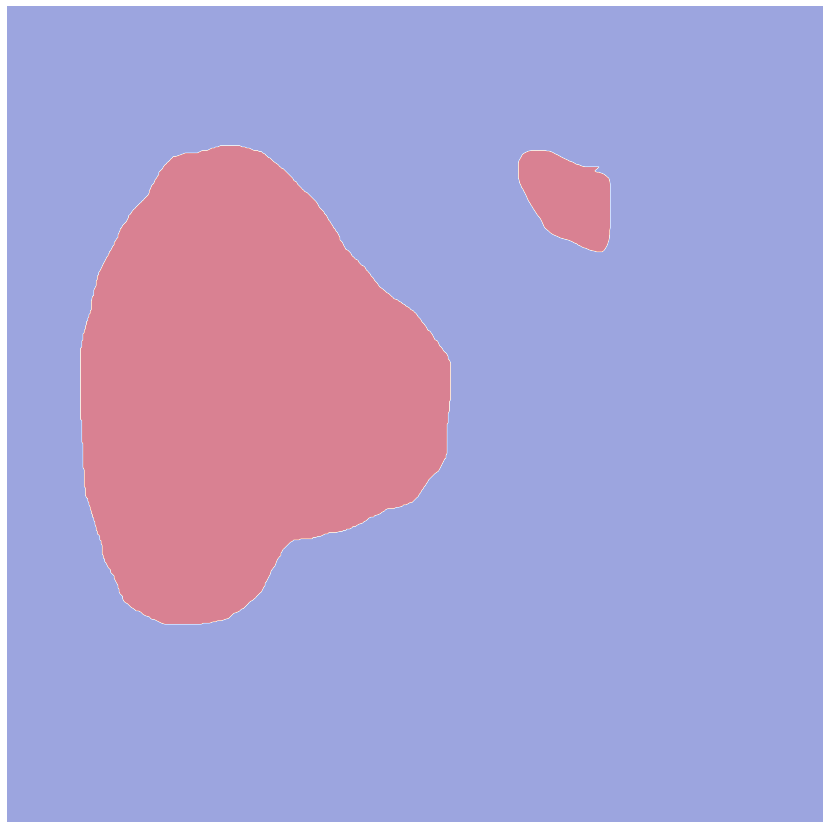

In [246]:
plt.figure(figsize=(15, 15))
plt.imshow(mask, cmap='coolwarm', alpha=0.5)
plt.axis("off")

## Combinando mask e image

(-0.5, 2999.5, 2999.5, -0.5)

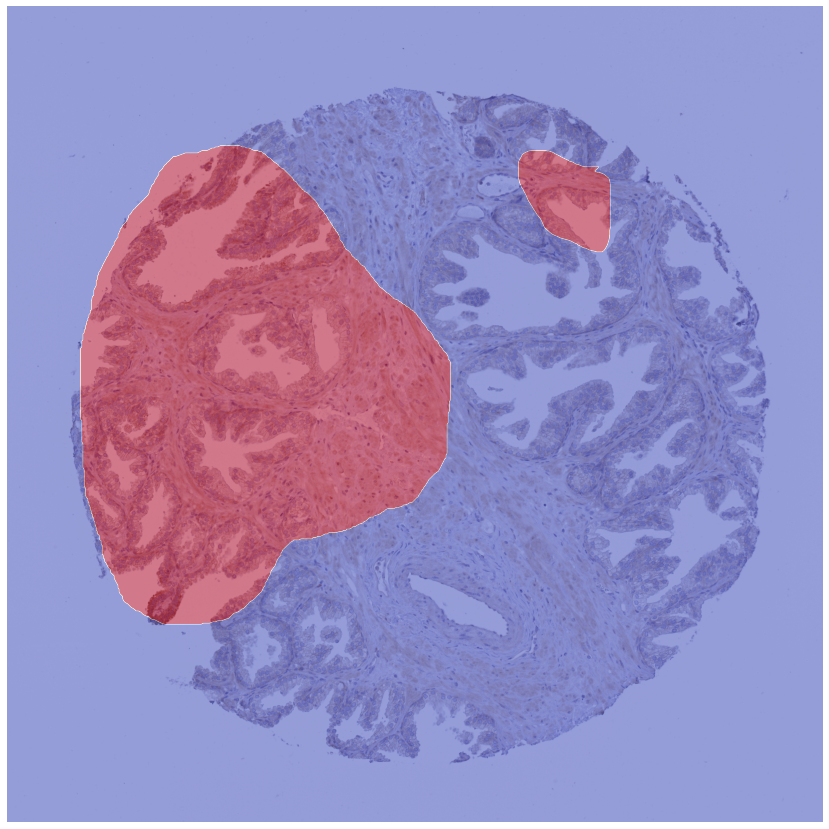

In [247]:
plt.figure(figsize=(15,15))
plt.imshow(image)
plt.imshow(mask, cmap='coolwarm', alpha=0.5)
plt.axis("off")

# Visualizacion

In [248]:
ds = HuBMAPDataset(train)
dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=False,)
it = iter(dl)
imgs,masks = next(it)

selected sample 62
selected sample 351
selected sample 737
selected sample 4301
selected sample 4777
selected sample 5086
selected sample 5995
selected sample 6021
selected sample 6120
selected sample 7359
selected sample 7397
selected sample 8227
selected sample 9517
selected sample 32412
selected sample 32741


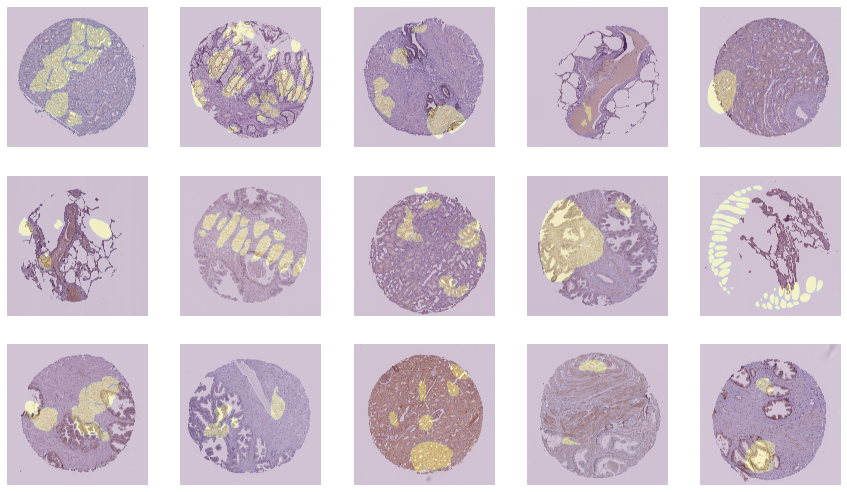

In [249]:
plt.figure(figsize=(15,15))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    plt.subplot(5,5,i+1)
    plt.imshow(img)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)